<a href="https://colab.research.google.com/github/kocurvik/BCS_results/blob/master/HUPV/notebooks/solutions/cv05_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trénovanie II.

Dnes si prejdeme konvolučné neurónové siete. Teda kovnolučné a poolingové vrstvy a k nim ďalšie vrstvy ako BatchNorm a Dropout. Prejdeme si tiež aj augmentáciu vstupného obrazu. Pozrieme sa aj na rôzne optimalizačné algoritmy



In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
from matplotlib import pyplot as plt

## Cifar-10

Dnes si načítame dataset cifar-10. Tento dataset obsahuje malé obrázky, ktoré su rozdelené na 10 kategórií.


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
torch.Size([1, 3, 32, 32])


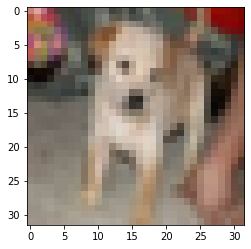

tensor([5])
dog
torch.Size([1, 3, 32, 32])


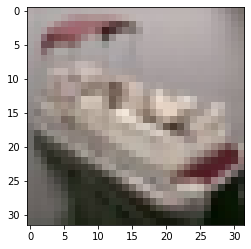

tensor([8])
ship
torch.Size([1, 3, 32, 32])


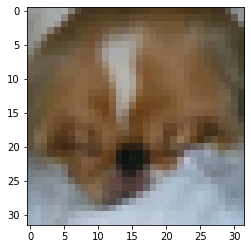

tensor([5])
dog
torch.Size([1, 3, 32, 32])


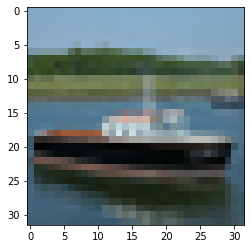

tensor([8])
ship
torch.Size([1, 3, 32, 32])


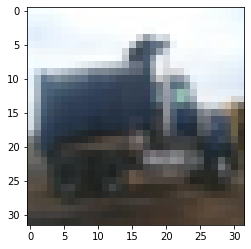

tensor([9])
truck
torch.Size([1, 3, 32, 32])


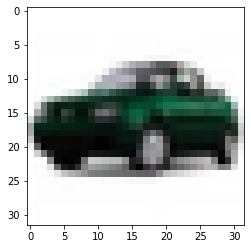

tensor([1])
car
torch.Size([1, 3, 32, 32])


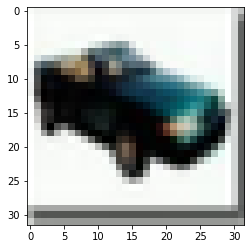

tensor([1])
car
torch.Size([1, 3, 32, 32])


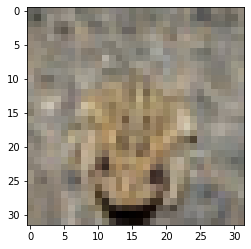

tensor([6])
frog
torch.Size([1, 3, 32, 32])


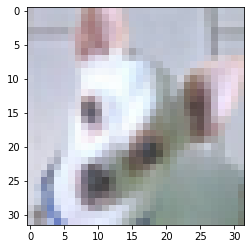

tensor([5])
dog
torch.Size([1, 3, 32, 32])


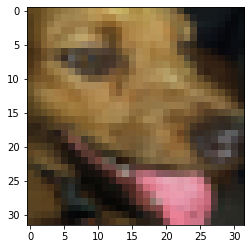

tensor([5])
dog
torch.Size([1, 3, 32, 32])


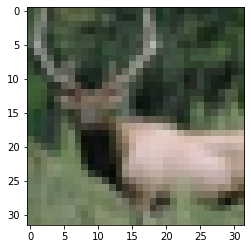

tensor([4])
deer


In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

transform = transforms.ToTensor()

dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# for reproducibility
trainset, valset = torch.utils.data.random_split(dataset, [45000, 5000], generator=torch.Generator().manual_seed(42))

previewloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)

for i, sample in enumerate(previewloader):
  if i > 10:
    break
  x, y = sample
  print(x.shape)
  img = np.moveaxis(x.numpy()[0], 0, -1)
  plt.imshow(img)
  plt.show()
  print(y)
  print(classes[y.item()])



## Konvolúcia

Ak by sme chceli používať pre počítačové videnie plne prepojené vrstvy, tak by sme narazili na problém s rýchlo narastajúcim množstvom parametrov. Veľké množstvo parametrov komplikuje trénovanie z hľadiska zložitosti priestoru nad ktorým optimalizujeme a taktiež vo výpočtovej náročnosti takejto optimalizácie.

Z tohto dôvodu sa najčastiejšie používajú tzv. konvolučné neurónové siete. Ich základom je konvolúcia. Tá je obecne definovaná na pre dve funkcie $f$ a $g$:

$$ (f \ast g)(t)  = \int_{-\infty}^{\infty} f(x) g(t - x) dx$$

Väčšinou sa používa ak je nosič jednej z funkcií obmedzený. V diskrétnom prípade pre "postupnosti" $a_i$ a $b_i$ pre $ i \in \mathbb{Z}$. Definujeme ako:

$$ (a \ast b)_j = \sum_{i \in \mathbb{Z}} a_i \cdot b_{j-i}$$.

V obraze však bežne však využívame dvojrozmernú verziu s veľmi malým jadrom o rozmeroch napr. $3 \times 3$, $5 \times 5$ atď. Keďže tieto jadrá sú pre bežné úlohy spracovania obrazu často symetrické, tak je bežne zamienaný pojem korelácie s konvolúciou (rozdiel je v znamienku vo výraze). Aplikáciu konvolúcie si tak môžeme predstaviť ako prenásobenie okolia nejakého bodu maskou a následné sčítanie daných hodnôt. Na obrázku znázornené ako:

![alt text](https://i.stack.imgur.com/YDusp.png)

Takýto postup sa bežne používa pri detekcii hrán, alebo iných zaujímavých bodov v obraze. Konvolúcia je preto vhodná na využitie v neurónových sieťach. To realizujeme tak, že daná vrsvta siete aplikuje na jej vstup konvolúciu s jadrom ktorého váhy sa sieť učí pri tréningu.

Aby to nebolo moc jednoduché, tak tieto jadrá niesu len dvojrozmerné (napr. $3 \times 3$), ale trojrozmerné, kde tretí rozmer korešponduje s počtom kanálov na vstupe do vrstvy. Každá vrstva má týchto jadier viacero a výstupom z nej tak bude obraz, alebo mapa príznakov s počtom kanálov rovným počtu jadier.

Pri konvolúcii ešte musíme myslieť na to čo robiť na okrajoch. Prístupy sú rôzne. Niekedy jadro prikladáme tak, že nikdy neprekočíme okraj. To ale spôsobí, že výstupný obraz bude mať iné rozmery ako vstupný. Ak nám to nevyhovuje, tak môžeme časti za okrajom obrazu považivať za nuly, prípadne brať hodnoty z opačnej strany obrazu. Pridanie núl sa označuje ako padding. Ďalšou modifikáciou je tzv. stride, teda, že jadro neprikladáme vždy o jedno políčko vedľa, ale nejaké preskočíme.

Pre jeden rozmer výstupného obrazu (samostatne šírka alebo výška) potom platí:

$$ N_{out} = \frac{N_{in} - F + 2P}{S} + 1,$$

kde $N_{out}$ je výstupná veľkosť, $N_{out}$ je vstupná veľkosť, $F$ je veľkosť jadra a $P$ je padding.

*Pozn.:* Keďže v sieti máme viacero kanálov, tak je uplne možné brať do úvahy aj $1 \times 1$ konvolúciu. Tá nam totiž len redukuje počet kanálov.

## Pooling

Konvolúcia sa často používa s tzv. poolingovými vrstvami. Tie slúžia na to, aby sa veľkosť obrazu postupne zmenšovala, čo vedie na menšie pamäťové nároky a možnosť používania viacero kanálov v hlbších vrstvách siete. Táto vrstva rozdelí obraz na zopár oblastí napr. $2 \times 2$ štvorčeky zredukuje hodnoty v nich na jedno číslo. To sa robí veľmi často pomocou operácie maxima, alebo menej často priemeru.

![alt text](https://qph.fs.quoracdn.net/main-qimg-cf2833a40f946faf04163bc28517959c)

## Flatten a Globálny Pooling

Na konci sieťe je veľmi bežné použiť zopár plne prepojených vrstiev. Na to je však potrebné redukovať počet dimenzií (rád tenzoru). K tomu slúži vrstva Flatten, ktorá príznaky zoradí z obrazovej reprezentácie do vektoru.

Nie vždy je vhodné využiť takýto prístup keďže veľkosť vektoru potom môže byť strašne veľká. Namiesto toho sa tak často používa tzv. globálny pooling, ktorý funguje ako bežný pooling ale redukuje celý obraz prináležiaci jednému kanálu na jedno číslo. Tu sa narozdiel od bežného Poolingu používa často priemerovací pooling.

## Aktivačné funkcie

Výber aktivačnej funkcie je dôležitý pri konštrukcii architektúr hlbokých neurónových sietí. Viac sa s nimi zoznámite počas domácej úlohy. Dnes budeme používať aktivačnú funkciu ReLU (rectified linear unit), ktorá ma nazrozdiel od sigmoidu výhodu v tom, že sa veľmi rýchlo počíta a jej derivácia je buď jedna, alebo nula, čo pomáha riešiť problém tzv. miznúcich gradientov, ktorý nastáva pri využití sigmoidu. Preto budeme v dnešnom notebooku používať ReLU.

ReLU je síce populárna, ale má niektoré nie uplne vhodné vlastnosti. Tie riešia rôznymi spôsobmi jej variácie PReLU, ELU a Leaky ReLU s ktorými sa zoznámite v rámci domácej úlohy. 

## Optimalizácia

Zatiaľ sme používali na optimalizáciu SGD. To je ale veľmi senzitívne na nastavenie trénovacieho kroku. V dnešnom cvičení použiejeme metódu Adam. Rôzne metódy optimalizácie aj to ako reagujú na hyperparametre si takisto overíte v rámci domácej úlohy.

## Jednoduchý model CNN

Navrhneme si jednoduchý model pre konvolučnú neurónovú sieť.

Pre konvolučné vrstvy je prvý parameter počet vstupných kanálov, počet výstupných kanálov, a veľkosť konvolučných jadier. Ďalšie parametre sú stride, padding atď pre viac info konzultujte dokumentáciu.

Pre poolingové vrsvy je to veľkosť poolingového okna.

In [ ]:
from torch.nn import Sequential, Linear, ReLU, Softmax, Conv2d, MaxPool2d, Flatten, AvgPool2d

def build_model():
  # Na vstupe budu tri kanaly lebo mame RGB vstup
  model = Sequential(Conv2d(3, 32, 3), MaxPool2d(2), ReLU(), 
                    Conv2d(32, 64, 3), MaxPool2d(2), ReLU(),
                    Conv2d(64, 128, 3), MaxPool2d(2), ReLU(),
                    AvgPool2d(), 
                    Linear(512, 256), ReLU(), Linear(256, 128), ReLU(),
                    Linear(128, 10))

  model_inference = Sequential(model, Softmax())
  return model, model_inference


# overime ze model funguje - ak by sme napriklad za flatten dali zle cislo nefungovalo by to
model, model_inference = build_model()

model_inference(torch.from_numpy(np.zeros([1, 3, 32, 32], dtype=np.float32)))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor([[0.1054, 0.1029, 0.1045, 0.0932, 0.1047, 0.0931, 0.0969, 0.1063, 0.0977,
         0.0954]], grad_fn=<SoftmaxBackward>)

Model si natrénujeme. Aby sme nečakali tak dlho na zlepšenie presnosti, tak použijeme optimalizátor Adam.

In [ ]:
batch_size = 32

dataloader_train = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
dataloader_val = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)

model, model_inference = build_model()
ce_loss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for e in range(2):
  model.train()
  for i, batch in enumerate(dataloader_train):  
    x, y = batch  
    optimizer.zero_grad()

    out = model(x)
    loss = ce_loss(out, y)
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
      print("Loss at epoch: {} step {}: {}".format(e, i, loss.item()))

  model.eval()
  with torch.no_grad():
    val_losses = []
    correct = 0
    for i, batch in enumerate(dataloader_val):  
      x, y = batch  

      out = model(x)
      loss = ce_loss(out, y)
      acc = torch.sum(torch.argmax(out, dim=-1) == y)
      correct += acc.item()
      val_losses.append(loss.item())

    print("Val loss at epoch {}: {}".format(e, np.mean(val_losses)))
    print("Val acc at epoch {}: {}".format(e, correct / 10000))

Loss at epoch: 0 step 0: 2.3105556964874268
Loss at epoch: 0 step 100: 2.0304081439971924
Loss at epoch: 0 step 200: 1.9934464693069458
Loss at epoch: 0 step 300: 1.7349417209625244
Loss at epoch: 0 step 400: 1.6496598720550537
Loss at epoch: 0 step 500: 1.529030442237854
Loss at epoch: 0 step 600: 1.6301723718643188
Loss at epoch: 0 step 700: 1.8648654222488403
Loss at epoch: 0 step 800: 1.489243507385254
Loss at epoch: 0 step 900: 1.3946133852005005
Loss at epoch: 0 step 1000: 0.9908679723739624
Loss at epoch: 0 step 1100: 1.266024112701416
Loss at epoch: 0 step 1200: 1.1910135746002197
Loss at epoch: 0 step 1300: 1.290026307106018
Loss at epoch: 0 step 1400: 1.360695242881775
Val loss at epoch 0: 1.3308798982079622
Val acc at epoch 0: 0.2574
Loss at epoch: 1 step 0: 1.3743178844451904
Loss at epoch: 1 step 100: 1.4737783670425415
Loss at epoch: 1 step 200: 1.1118364334106445
Loss at epoch: 1 step 300: 1.661976933479309
Loss at epoch: 1 step 400: 1.2639858722686768
Loss at epoch: 1 s

## Výpočet na GPU

Počítanie na CPU je pomalé preto si budeme sieť púšťať na GPU. Najprv sa musíme uistiť, že naša inštancia má GPU pridelené. To si spravíte Menu Runtime -> Change runtime type v hornom menu (File Edit etc.).

Aké gpu sme dostali môžeme zistiť pomocou príkazu nvidia-smi

In [ ]:
!nvidia-smi

Tue Oct 26 16:04:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    34W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Potom ak cheme aby výpočet prebehol na GPU, tak musím všetky vstupy a aj model samotný prehodiť na gpu pomocou metódy to.

In [ ]:
def one_epoch(model, loss, optimizer, dataloader_train, dataloader_val, verbose=True):
  train_losses = []
  val_losses = []

  model.train()
  for i, batch in enumerate(dataloader_train):  
    x, y = batch[0].to(device), batch[1].to(device) 
    optimizer.zero_grad()

    out = model(x)
    loss = ce_loss(out, y)
    loss.backward()
    train_losses.append(loss.item())
    optimizer.step()
    if i % 100 == 0 and verbose:
      print("Training loss at step {}: {}".format(i, loss.item()))

  model.eval()
  with torch.no_grad():
    correct = 0
    total = 0
    for i, batch in enumerate(dataloader_val):  
      x, y = batch[0].to(device), batch[1].to(device)  

      out = model(x)
      loss = ce_loss(out, y)
      acc = torch.sum(torch.argmax(out, dim=-1) == y)
      correct += acc.item()
      total += len(batch[1])
      val_losses.append(loss.item())

  val_acc = correct / total

  return np.mean(train_losses), np.mean(val_losses), val_acc

Using device:  cuda:0
Training loss at step 0: 2.3006389141082764
Training loss at step 100: 2.105759382247925
Training loss at step 200: 2.170393705368042
Training loss at step 300: 1.7547180652618408
Training loss at step 400: 1.8165494203567505
Training loss at step 500: 1.5162479877471924
Training loss at step 600: 1.7999006509780884
Training loss at step 700: 1.7247014045715332
Training loss at step 800: 1.5285903215408325
Training loss at step 900: 1.5547125339508057
Training loss at step 1000: 1.673585057258606
Training loss at step 1100: 1.4037493467330933
Training loss at step 1200: 1.8075687885284424
Training loss at step 1300: 1.2890002727508545
Training loss at step 1400: 1.1505088806152344
Val loss at epoch 0: 1.3998719051385382
Val acc at epoch 0: 0.4938
Training loss at step 0: 1.2495524883270264
Training loss at step 100: 1.3292871713638306
Training loss at step 200: 1.29820716381073
Training loss at step 300: 1.4730982780456543
Training loss at step 400: 1.206950068473

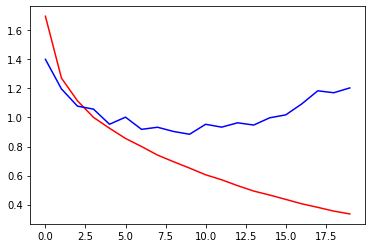

In [ ]:
batch_size = 32

dataloader_train = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
dataloader_val = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

ce_loss = torch.nn.CrossEntropyLoss().to(device)

model, model_inference = build_model()

model.to(device)
model_inference.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epoch_train_losses = []
epoch_val_losses = []
epoch_val_accs = []

for e in range(20):
  train_loss, val_loss, val_acc = one_epoch(model, loss, optimizer, dataloader_train, dataloader_val)

  print("Val loss at epoch {}: {}".format(e, val_loss))
  print("Val acc at epoch {}: {}".format(e, val_acc))

  epoch_train_losses.append(train_loss)
  epoch_val_losses.append(val_loss)
  epoch_val_accs.append(val_acc)
  
plt.plot(epoch_train_losses, c='r')
plt.plot(epoch_val_losses, c='b')
plt.show()

## Dropout

Minule sme si ukazovali L1 a L2 regularizáciu. Dnes si ukážeme metódu Dropout. Tá spočíva v tom, že niektoré prepojenia (s pravedepodobnosťou $p$) sieť nastaví na nulu. To zabráni koadaptácii príznakov. Teda ak náhodou dva príznaky reprezentujú do isté, tak by sa nemali šancu naučiť každý niečo iné, lebo vždy budú ich gradienty a teda aj zmena po každom kroku rovnaká (aspoň približne). Ak však pridáme dropout majú tieto príznaky možnosť sa odlúčiť od seba, čo je pozitívne. Iný pohľad na vec je taký, že vlastne trénujeme viacero modelov naraz (tj. toľko modelov koľko existuje kombinácii kde sa niektore váhy ignorujú) a na konci ich spojíme a spriemerujeme ich výsledok.

## BatchNormalization

Normalizácia dávok rieši problém vnútorného kovariančného posunu (internal covarience shift) v rámci siete. Ten spôsobuje že príznaky nemajú vhodnú distribúciu v rámci siete. To je dôležité najmä pre hlbšie siete.

BatchNorm funguje tak, že pre každý minibatch sa vypočíta stredná hodnota a štandardná odchylka príznakov na danej vrstve. Príznaky sa potom normalizujú odčítanim priemeru a podelením štd. odchylkou:

$$\hat{x} = \frac{x - \bar{x}}{\sqrt{\sigma^2(x) + \epsilon}}.$$

Keďže však normálna distribúcia nieje vždy žiadúca má táto vrstva ešte dva trénovateľné parametre $\gamma$ a $\beta$:

$$y = \gamma \hat{x} + \beta.$$

To umožní naučiť sa iný tvar distribúcie, ktorý je pre sieť vhodnejší.

Pri inferencii nedostávame dávku, resp. ju nedostávame náhodne. Preto si vrstva po trénovaní pamätá priemer a štd. odchylku.

BatchNorm sa bežne aplikuje pred activačnou funkciou. Doteraz sme ju mali určenú v inej vrstve teraz ju spravíme samostatne.



Naimplementujeme si teda build model funkciu, ktorá dokáže model načítať ak zadáme cestu k uloženému checkpointu a zároveň vie pridať dropout a batchnorm

In [ ]:
from torch.nn import Sequential, Linear, ReLU, Softmax, Conv2d, MaxPool2d, Flatten, BatchNorm2d, BatchNorm1d, Dropout

def build_model(path=None, dropout_p=0.5, bn=True):
  # Na vstupe budu tri kanaly lebo mame RGB vstup

  modules = []
  modules.append(Conv2d(3, 32, 3))
  if bn:
    modules.append(BatchNorm2d(32))
  modules.append(MaxPool2d(2))
  modules.append(ReLU())

  modules.append(Conv2d(32, 64, 3))
  if bn:
    modules.append(BatchNorm2d(64))
  modules.append(MaxPool2d(2))
  modules.append(ReLU())

  modules.append(Conv2d(64, 128, 3))
  if bn:
    modules.append(BatchNorm2d(128))
  modules.append(MaxPool2d(2))
  modules.append(ReLU())

  modules.append(Flatten())

  modules.append(Linear(512, 256))
  if bn:
    modules.append(BatchNorm1d(256))
  modules.append(ReLU())
  if dropout_p > 0.0:
    modules.append(Dropout(dropout_p))

  modules.append(Linear(256, 128))
  if bn:
    modules.append(BatchNorm1d(128))
  modules.append(ReLU())
  if dropout_p > 0.0:
    modules.append(Dropout(dropout_p))

  modules.append(Linear(128, 10))
  
  model = Sequential(*modules)

  if path is not None:
    model.load_state_dict(torch.load(path))

  model_inference = Sequential(model, Softmax())
  return model, model_inference


# overime ze model funguje - ak by sme napriklad za flatten dali zle cislo nefungovalo by to
model, model_inference = build_model()

model_inference(torch.from_numpy(np.zeros([16, 3, 32, 32], dtype=np.float32)))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor([[0.0983, 0.1054, 0.1011, 0.0961, 0.0966, 0.1040, 0.1024, 0.0915, 0.1008,
         0.1038],
        [0.0983, 0.1055, 0.1011, 0.0961, 0.0966, 0.1040, 0.1024, 0.0915, 0.1008,
         0.1038],
        [0.0983, 0.1055, 0.1011, 0.0961, 0.0966, 0.1040, 0.1024, 0.0915, 0.1008,
         0.1038],
        [0.0983, 0.1055, 0.1011, 0.0961, 0.0966, 0.1040, 0.1024, 0.0915, 0.1008,
         0.1038],
        [0.0983, 0.1055, 0.1011, 0.0961, 0.0966, 0.1040, 0.1024, 0.0915, 0.1009,
         0.1038],
        [0.0983, 0.1055, 0.1011, 0.0961, 0.0966, 0.1040, 0.1024, 0.0915, 0.1008,
         0.1038],
        [0.0983, 0.1055, 0.1011, 0.0961, 0.0966, 0.1040, 0.1024, 0.0915, 0.1009,
         0.1038],
        [0.0983, 0.1055, 0.1011, 0.0961, 0.0966, 0.1039, 0.1024, 0.0915, 0.1008,
         0.1038],
        [0.0983, 0.1055, 0.1011, 0.0961, 0.0966, 0.1039, 0.1024, 0.0915, 0.1008,
         0.1038],
        [0.0983, 0.1055, 0.1011, 0.0961, 0.0966, 0.1040, 0.1024, 0.0915, 0.1009,
         0.1038],
        [0

## Augmentácia dát
Na vylepšenie modelu by bolo dobré mať viac dát. Tie však len tak zohnať nevieme. Preto si pomôžeme augmentáciou. Tá spočíva v aplikácii transformácií, ktoré nemenia sémantický obsah obrazu. Augmentácia sa dá poňať aj tak, že chceme aby naša sieť bola invariantná voči týmto transformáciám.

Prakticky využijeme augmentáciu tak, že modifujeme parameter transforms pri načítaní datasetu.

Files already downloaded and verified
torch.Size([1, 3, 32, 32])


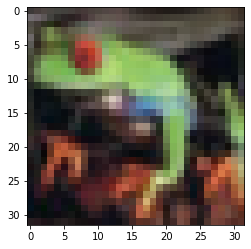

tensor([6])
frog
torch.Size([1, 3, 32, 32])


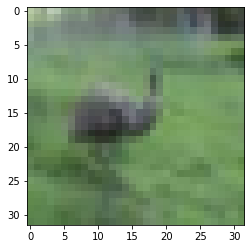

tensor([2])
bird
torch.Size([1, 3, 32, 32])


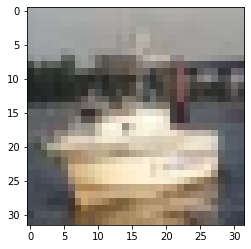

tensor([8])
ship
torch.Size([1, 3, 32, 32])


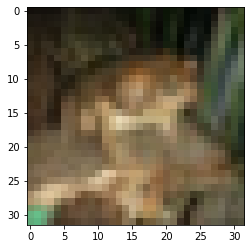

tensor([6])
frog
torch.Size([1, 3, 32, 32])


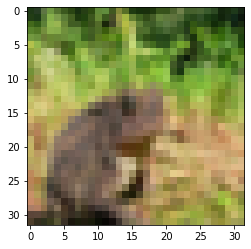

tensor([6])
frog
torch.Size([1, 3, 32, 32])


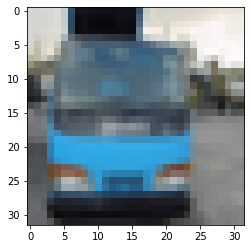

tensor([9])
truck
torch.Size([1, 3, 32, 32])


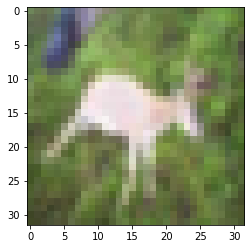

tensor([4])
deer
torch.Size([1, 3, 32, 32])


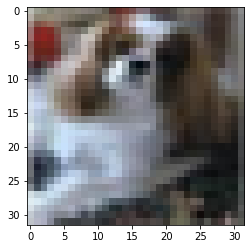

tensor([5])
dog
torch.Size([1, 3, 32, 32])


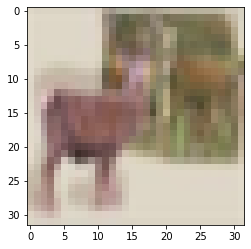

tensor([4])
deer
torch.Size([1, 3, 32, 32])


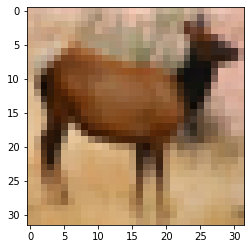

tensor([4])
deer
torch.Size([1, 3, 32, 32])


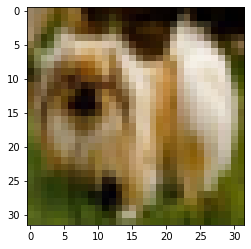

tensor([5])
dog
Files already downloaded and verified
torch.Size([1, 3, 32, 32])


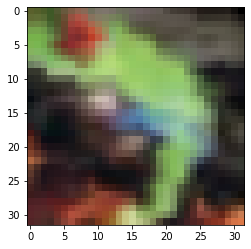

tensor([6])
frog
torch.Size([1, 3, 32, 32])


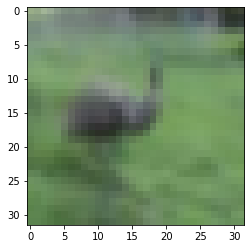

tensor([2])
bird
torch.Size([1, 3, 32, 32])


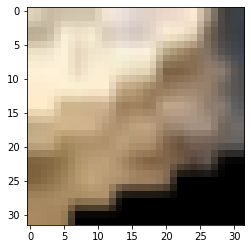

tensor([8])
ship
torch.Size([1, 3, 32, 32])


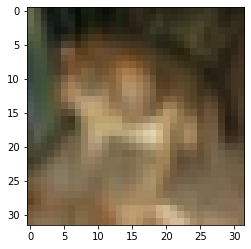

tensor([6])
frog
torch.Size([1, 3, 32, 32])


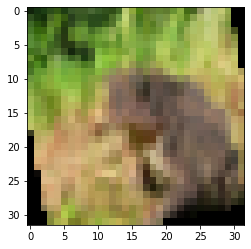

tensor([6])
frog
torch.Size([1, 3, 32, 32])


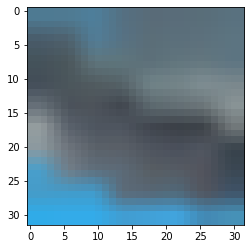

tensor([9])
truck
torch.Size([1, 3, 32, 32])


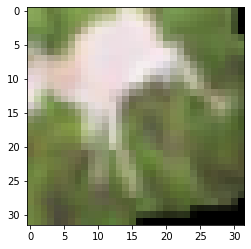

tensor([4])
deer
torch.Size([1, 3, 32, 32])


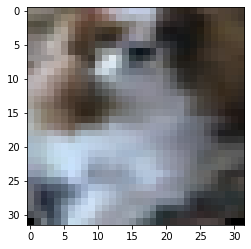

tensor([5])
dog
torch.Size([1, 3, 32, 32])


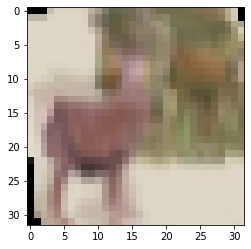

tensor([4])
deer
torch.Size([1, 3, 32, 32])


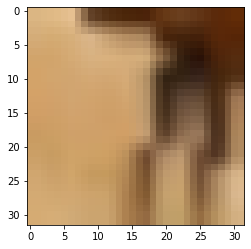

tensor([4])
deer
torch.Size([1, 3, 32, 32])


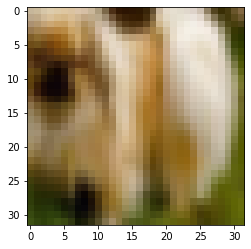

tensor([5])
dog


In [ ]:
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


trainset, valset = torch.utils.data.random_split(dataset, [45000, 5000], generator=torch.Generator().manual_seed(42))

dataloader_preview_aug = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=False)

for i, sample in enumerate(dataloader_preview_aug):
  if i > 10:
    break
  x, y = sample
  print(x.shape)
  img = np.moveaxis(x.numpy()[0], 0, -1)
  plt.imshow(img)
  plt.show()
  print(y)
  print(classes[y.item()])


aug_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                     transforms.RandomRotation(20),
                                     transforms.RandomResizedCrop(size=(32, 32)),
                                     transforms.ToTensor()])

dataset_aug = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=aug_transforms)

# tu musime dat rovnaky seed aby sme mali val a train disjunktne
trainset_aug, _ = torch.utils.data.random_split(dataset_aug, [45000, 5000], generator=torch.Generator().manual_seed(42))
dataloader_preview_aug = torch.utils.data.DataLoader(trainset_aug, batch_size=1, shuffle=False)

for i, sample in enumerate(dataloader_preview_aug):
  if i > 10:
    break
  x, y = sample
  print(x.shape)
  img = np.moveaxis(x.numpy()[0], 0, -1)
  plt.imshow(img)
  plt.show()
  print(y)
  print(classes[y.item()])

Keď to dáme dokopy mali by sme predísť overfittingu.

Using device:  cuda:0
Training loss at step 0: 2.5489416122436523
Training loss at step 100: 2.1635637283325195
Training loss at step 200: 1.9727193117141724
Training loss at step 300: 1.9680272340774536
Training loss at step 400: 1.8626214265823364
Training loss at step 500: 1.9779037237167358
Training loss at step 600: 1.701088786125183
Training loss at step 700: 1.9179306030273438
Training loss at step 800: 2.133100986480713
Training loss at step 900: 1.8964042663574219
Training loss at step 1000: 1.7266491651535034
Training loss at step 1100: 1.915705680847168
Training loss at step 1200: 1.8336598873138428
Training loss at step 1300: 1.666725516319275
Training loss at step 1400: 1.584696888923645
Val loss at epoch 0: 1.532359515026117
Val acc at epoch 0: 0.4596
Training loss at step 0: 1.5195624828338623
Training loss at step 100: 1.6918355226516724
Training loss at step 200: 2.0371387004852295
Training loss at step 300: 1.862838864326477
Training loss at step 400: 1.59487736225128

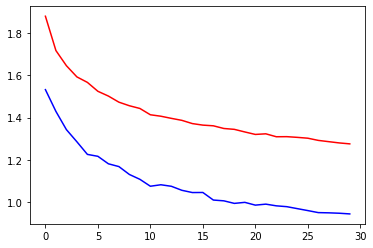

In [ ]:
batch_size = 32

dataloader_train = torch.utils.data.DataLoader(trainset_aug, batch_size=batch_size, shuffle=True)
dataloader_val = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

ce_loss = torch.nn.CrossEntropyLoss().to(device)

model, model_inference = build_model(dropout_p=0.5, bn=True)

model.to(device)
model_inference.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epoch_train_losses = []
epoch_val_losses = []
epoch_val_accs = []

for e in range(30):
  train_loss, val_loss, val_acc = one_epoch(model, loss, optimizer, dataloader_train, dataloader_val)

  print("Val loss at epoch {}: {}".format(e, val_loss))
  print("Val acc at epoch {}: {}".format(e, val_acc))

  torch.save(model.state_dict(), "{:03d}.pth".format(e))
  epoch_train_losses.append(train_loss)
  epoch_val_losses.append(val_loss)
  epoch_val_accs.append(val_acc)
  
plt.plot(epoch_train_losses, c='r')
plt.plot(epoch_val_losses, c='b')
plt.show()

## Načítanie uloženého modelu

Keďže sme si model aj uložili môžeme si ho načítať a napríklad spustiť na trénovacích dátach. Stačí nám do funkcie build model pridať cestu k uloženému modelu.

In [ ]:
batch_size = 32

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

dataloader_test = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

model, model_inference = build_model('005.pth', dropout_p=0.5, bn=True)
model_inference.to(device)

# Potrebujeme aby sme zmenili formu batchnorm
model_inference.eval()

with torch.no_grad():
  correct = 0
  total = 0
  for i, batch in enumerate(dataloader_val):  
    x, y = batch[0].to(device), batch[1].to(device)  

    out = model(x)
    loss = ce_loss(out, y)
    acc = torch.sum(torch.argmax(out, dim=-1) == y)
    correct += acc.item()
    total += len(batch[1])
  
acc = correct / total
print("Test set accuracy: ", acc)


Using device:  cuda:0
Test set accuracy:  0.637


# Domáca úloha

Prvá domáca úloha bude spočívať v praktickom testovaní vecí, ktoré sme si práve spomínali. Je rozložená na viaceré časti. Výstupom z úlohy môže byť buď viacero notebookov, alebo python skriptov, ktorými ste spúštali experimenty. Výstupom má byť takisto pdf súbor s výsledkami a grafmi, ktoré budú demonštrovať vaše tvrdenia.

Jadrom domácej úlohy bude trénovanie siete na datasete Cifar-10. Vždy potom budete porovnávať ako rôzne modifikácie siete fungujú voči iným prípadne voči nejakému baselinu. Úloha sa bude skladať z viacerých častí.

*Pozn.:*  Úlohu môžete riešiť aj v Kerase.

### Základný model (1b)

Cieľ je navrhnúť idálne čo najrýchlejší model, ktorý bude dosahovať cca. 70 percentnú presnosť na datasete Cifar-10. Tento model bude slúžiť ako baseline pre ďalšie modifikácie. V rámci modelu použite optimalizátor Adam a aktivácie ReLU. Začiatok modelu by mal pozostávať zo zopár konvolučných a poolingových vrstiev. Na konci by mala byť plne prepojená časť.

V naselujúcich podúlohách je nutné zmeniť vždy nejakú časť modelu a porovnať ich navzájom pomocou grafov, ktoré ukazujú vývoj validačnej presnosti a chyby. Namiesto grafov je možné použiť tabuľku, ale v nej je zmysluplné uvádzať len hodnoty na konci trénovania.

### Aktivácie (3b)

Vyskúšajte vymeniť aktivačné funkcie. Otestujte tri z nasledovných aktivačných funkcií sigmoid, tanh, ELU, LeakyReLU a PReLU. LeakyReLU môžete otestovať aj pre rôzne hodnoty parametru alpha (napr. 0.3, 0.1, 0,03). 

### Optimalizácia (6b)

Otestujte trénovanie pomocou optimalizátorov Adam, SGD alebo RMSProp. Spustite aspoň 4 rôzne konfigurácie (rôzne kroky, rôzne alpha, beta atď). Pre túto úlohu je vhodné využiť v pdfku grafy. 

Jednu metódu si vyberte a otestujte pre ňu navyše ďalšie tri veľkosti minibatchov.

### Dropout a Augmentácia (6b)

Dropout otestujte tak, že bude najprv len v plne prepojenej vrstve (p = 0.5) a potom aj po konvolučných vrstvách (p = 0.2). A ešte jednu možnosť navyše. Pri použití v konvolučných vrstvách nezabudnite, že treba použiť Dropout2d namiesto Dropout1d.

Augmentáciu testujte pre 3 rôzne nastavania. Môžte byť aj kreatívny, ale malo by to mať aspoň nejaký zmysel. Dokumentáciu nájdete [tu](https://pytorch.org/vision/stable/transforms.html). Dávajte si pritom pozor aby ste to spravili správne.

Obe veci testujte pre dva prípady v jednom použijete bežný split na train/val a v druhom nechajte v trénovacej množine iba prvých 1000 príkladov. Uvedomte si, že počet trénovacích krokov je pre druhý prípad menší použite preto úmerne viac epôch.

### Hlboká sieť (5b)

Navrhnite hlbokú (stačí aj úzku, ale nech má aspoň 11 vrstiev) sieť. Otestujte ju najprv bez BatchNorm, reziduálnych alebo dense prepojení, alebo prídavných trenovacích vrstiev. Nakoniec otestujte aspoň dva z týchto prístupov, tak aby ste mali aspoň 3 rôzne modely (tj. rôzne rozmiestnenie týchto prvkov).

Pozn.: Ak chcete testovať reziduálne, alebo dense prepojenia, tak navrhnite sieť tak, aby ich bolo kam dať.

### Najlepší model (3b)

Vytvorte model, ktorý dosiahne najlepší vylsedok, aký len viete. Tieto body sú navyše a nerátajú sa do celkového počtu bodov. Bude sa prihliadať na to aké modely odovzdali ostatní. Model zašlite vo formáte ako .pth torchovský state dict spolu s jedným skriptom, ktorý model načíta a spočíta presnosť na testovacej množine Cifar-10. Váš postup pre tvorbu modelu popíšte. Môžete sa inšpirovať internetom, ale nesťahujte ani nepoužívajte predtrénované modely. Ak už sa inšpirijete niečim až príliš, tak aspoň popíšte prečo by práve ten model mal fungovať dobre (tu prosím nepíšte, že preto že blog to tvrdí).

## Hodnotenie

Úloha je relatívne priamočiara, keďže jej cieľ je skôr nadobudnutie skúseností. Problém bude skôr s časom. Pri úlohách si môžete väčšinou vybrať viacere parametre. Preto nevadí ak niektoré z nich budú nezmyselné ako napr. veľmi veľký krok učenia, keďže vedieť co nefunguje je tiež dôležité. Budem však strhávať body ak v nejakej sekcii nebudú skoro žiadne nastavenia, ktoré dávaju zmysel/dobré výsledky. Ideálne by bolo ak by ste sa snažili napr. po prvých troch nastaveniach snažili nájsť to "najlepšie". Súčasťou pdfka, ktoré odovzdáte bude aj komentár, ak sa v ňom vyskytne nejaký nezmysel, tak tiež budem strhávať.

## Odovzdávanie

Úlohu odovzdajte v zipe s notebookmi/skriptami, pdfkom s výsledkami a vašim modelom na mailovú adresu kocurvik@gmail.com Pdfko rozdelte na sekcie ako tu a ideálne aj do podeskcií kde to dáva zmysel. K výsledkom vždy vypíšte komentár ako dopadli.

Deadline je do **12.11. 23:59**. Pri neskoršom odovzdaní budem strhávať body.


## Domáca úloha č. 1 (20b) - Alternatíva

Ako alternatívu prvej domácej úlohy je možné jeden z notebookov z cvičení prepísať do iného frameworku. Cieľové frameworky môžu byť JAX a PyTorch. Ak máte záujem o túto formu prvej domácej úlohy, tak je nutné tento postup prekonzultovať aspoň týždeň týždeň pred deadlinom originálneho zadania.

# Zložitejšie modely

Ukážeme si napríklad ako z modelu vyhodiť dva výstupy a ako prijať dva vstupy a podobne. Najprv teda príklad ak by sme chceli klasifikovať jednak aké číslo sme dostali a potom to, či je párne, alebo nie.

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')

x_np = mnist.data.astype('float32')/255
labels_np = mnist.target.astype('int64')

images = torch.from_numpy(x_np)
labels = torch.from_numpy(labels_np)

## torch.nn.Module

Komplikovanejšiu sieť nemôžeme vyrobiť pomocou konštruktora Sequential, ale musíme si subclassnúť torch.nn.Module a implementovať konštruktor, kde si definujeme vrstvya metódu forward kde definujeme výpočet.

In [ ]:
from torch.nn import Module, Linear
from torch.nn.functional import relu, sigmoid

class TwoOutputNet(Module):
    def __init__(self):
        super(TwoOutputNet, self).__init__()
        self.fc1 = Linear(28 * 28, 30)
        self.fc2 = Linear(30, 20)
        self.fc_classes = Linear(20, 10)
        self.fc_odd_even = Linear(20, 1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = relu(x)
        x = self.fc2(x)
        x = relu(x)
        x_class = self.fc_classes(x)
        x_odd_even = self.fc_odd_even(x)
        x_odd_even = sigmoid(x_odd_even)

        return [x_class, x_odd_even]

model = TwoOutputNet()

out = model(torch.ones([4, 28*28]))

print(out)

[tensor([[-0.0023,  0.1268,  0.3411,  0.1393,  0.1961,  0.1488,  0.1650,  0.0517,
         -0.1738, -0.2913],
        [-0.0023,  0.1268,  0.3411,  0.1393,  0.1961,  0.1488,  0.1650,  0.0517,
         -0.1738, -0.2913],
        [-0.0023,  0.1268,  0.3411,  0.1393,  0.1961,  0.1488,  0.1650,  0.0517,
         -0.1738, -0.2913],
        [-0.0023,  0.1268,  0.3411,  0.1393,  0.1961,  0.1488,  0.1650,  0.0517,
         -0.1738, -0.2913]], grad_fn=<AddmmBackward>), tensor([[0.4839],
        [0.4839],
        [0.4839],
        [0.4839]], grad_fn=<SigmoidBackward>)]


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


## Zobrazenie architektúry

Ak chceme vidieť ako vyzerá celá architektúra, tak môžeme jednoducho printnúť model.

In [ ]:
print(model)

TwoOutputNet(
  (fc1): Linear(in_features=784, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=20, bias=True)
  (fc_classes): Linear(in_features=20, out_features=10, bias=True)
  (fc_odd_even): Linear(in_features=20, out_features=1, bias=True)
)


To však neuvidíme prepojenia. Preto môžeme použiť tensorboard. Najprv si vytvoríme TensorBoard SummaryWriter a potom do neho dáme našu sieť aj so vstupom.

In [ ]:
from torch.utils.tensorboard import SummaryWriter

model = TwoOutputNet()
writer = SummaryWriter('tb/run')
writer.add_graph(model, torch.ones([1, 28*28]))
writer.close()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/torch/jit/_trace.py:959: TracerWarning: Encountering a list at the output of the tracer might cause the trace to be incorrect, this is only valid if the container structure does not change based on the module's inputs. Consider using a constant container instead (e.g. for `list`, use a `tuple` instead. for `dict`, use a `NamedTuple` instead). If you absolutely need this and know the side effects, pass strict=False to trace() to allow this behavior.
  argument_names,


Potom si môžeme loadnúť tzv. magic v notebooku, ktorý nám umožní zobraziť tensorboard.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir tb

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

data_train = TensorDataset(images[:50000], labels[:50000])
dataloader_train = DataLoader(data_train, batch_size=32, shuffle=True)

data_val = TensorDataset(images[50000:60000], labels[50000:60000])
dataloader_val = DataLoader(data_val, batch_size=32)

model = TwoOutputNet()

ce_loss = torch.nn.CrossEntropyLoss()
binary_loss = torch.nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for e in range(10):
  model.train()
  for i, batch in enumerate(dataloader_train):  
    x, y = batch  
    optimizer.zero_grad()

    out_classes, out_odd_even = model(x)
    loss = ce_loss(out_classes, y) + binary_loss(torch.squeeze(out_odd_even), (y % 2).float())
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
      print("Loss at epoch: {} step {}: {}".format(e, i, loss.item()))

  model.eval()
  with torch.no_grad():
    val_losses = []
    correct_classes = 0
    correct_odd_even = 0
    for i, batch in enumerate(dataloader_val):  
      x, y = batch  

      out_classes, out_odd_even = model(x)
      loss = ce_loss(out_classes, y) + binary_loss(torch.squeeze(out_odd_even), (y % 2).float())
      acc_classes = torch.sum(torch.argmax(out_classes, dim=-1) == y)  
      acc_odd_even = torch.sum(torch.where(torch.squeeze(out_odd_even) > 0.5, 1, 0) == (y % 2).float())
      correct_classes += acc_classes.item()
      correct_odd_even += acc_odd_even.item()
      val_losses.append(loss.item())

    print("Val loss at epoch {}: {}".format(e, np.mean(val_losses)))
    print("Val acc classes at epoch {}: {}".format(e, correct_classes / 10000))
    print("Val acc odd-even at epoch {}: {}".format(e, correct_odd_even / 10000))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Loss at epoch: 0 step 0: 3.0136687755584717
Loss at epoch: 0 step 100: 1.5439887046813965
Loss at epoch: 0 step 200: 1.0723457336425781
Loss at epoch: 0 step 300: 0.9225047826766968
Loss at epoch: 0 step 400: 1.0625216960906982
Loss at epoch: 0 step 500: 0.6877797842025757
Loss at epoch: 0 step 600: 0.6816473007202148
Loss at epoch: 0 step 700: 0.5729663372039795
Loss at epoch: 0 step 800: 0.6154147386550903
Loss at epoch: 0 step 900: 0.6204397678375244
Loss at epoch: 0 step 1000: 0.37178343534469604
Loss at epoch: 0 step 1100: 0.519706130027771
Loss at epoch: 0 step 1200: 0.2374235987663269
Loss at epoch: 0 step 1300: 0.3027026057243347
Loss at epoch: 0 step 1400: 0.1877288520336151
Loss at epoch: 0 step 1500: 0.34767037630081177
Val loss at epoch 0: 0.34920006156110533
Val acc classes at epoch 0: 0.934
Val acc odd-even at epoch 0: 0.959
Loss at epoch: 1 step 0: 0.5225335955619812
Loss at epoch: 1 step 100: 0.3285427689552307
Loss at epoch: 1 step 200: 0.2670252323150635
Loss at epoch

## Úloha 1

Napíšte kód ktorý natrénuje sieť, ktorá naopak bude mať na vstupe dva obrázky a z nich spočíta či je ich súčet párny alebo nepárny. Implementujte sieť tak aby mala dve samostatné vetvy na výpočet. Môžete sa pritom rozhodnúť, či chcete aby napríklad obe vetvy mali zdieľané, alebo samostatné váhy.

Potom vetvy spojíte a aplikujete aspoň jednu ďalšiu skrytú vrstvu. Na spojenie vetiev môžete použiť napríklad torch.cat


In [ ]:
class TwoInputNet(Module):
  def __init__(self):
    super(TwoInputNet, self).__init__()
    self.fc1 = Linear(28 * 28, 30)
    self.fc2 = Linear(30, 20)
    self.fc3 = Linear(40, 10)
    self.fc_odd_even = Linear(10, 1)
        
  def forward(self, input):
    x_1, x_2 = input
    x_1 = self.fc1(x_1)
    x_1 = relu(x_1)
    x_1 = self.fc2(x_1)
    x_1 = relu(x_1)
    
    x_2 = self.fc1(x_2)
    x_2 = relu(x_2)
    x_2 = self.fc2(x_2)
    x_2 = relu(x_2)

    x = torch.cat([x_1, x_2], dim=-1)
    x = self.fc3(x)
    x = relu(x)

    x_odd_even = self.fc_odd_even(x)
    x_odd_even = torch.sigmoid(x_odd_even)

    return x_odd_even

V rámci trénovania vám trocha pomôžem s tým ako generovať páry dát. Spravíme si dva generátory a oba budú vždy vyhadzovať náhodné čísla. V tomto prípade budeme náhodne premiešavať aj validačnú množinu aby sme nemali len rovnaké páry.



In [ ]:
data_train = TensorDataset(images[:50000], labels[:50000])
dataloader_train_1 = DataLoader(data_train, batch_size=32, shuffle=True)
dataloader_train_2 = DataLoader(data_train, batch_size=32, shuffle=True)

data_val = TensorDataset(images[50000:60000], labels[50000:60000])
dataloader_val_1 = DataLoader(data_val, batch_size=32, shuffle=True)
dataloader_val_2 = DataLoader(data_val, batch_size=32, shuffle=True)

model = TwoInputNet()

binary_loss = torch.nn.BCELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

for e in range(10):
  model.train()
  for i, batch in enumerate(zip(dataloader_train_1, dataloader_train_2)):  
    x_1, y_1 = batch[0]
    x_2, y_2 = batch[1]
    optimizer.zero_grad()

    # print((y_1 + y_2) % 2)

    out_odd_even = model([x_1, x_2])

    # print(out_odd_even)
    # print(((y_1 + y_2) % 2).float())

    loss = binary_loss(torch.squeeze(out_odd_even), ((y_1 + y_2) % 2).float())
    loss.backward()    
    optimizer.step()
    if i % 100 == 0:
      print("Loss at epoch: {} step {}: {}".format(e, i, loss.item()))

  model.eval()
  with torch.no_grad():
    val_losses = []
    correct_odd_even = 0
    for i, batch in enumerate(zip(dataloader_val_1, dataloader_val_2)):  
      x_1, y_1 = batch[0]
      x_2, y_2 = batch[1]

      out_odd_even = model([x_1, x_2])
      loss = binary_loss(torch.squeeze(out_odd_even), ((y_1 + y_2) % 2).float())
      acc_odd_even = torch.sum(torch.where(torch.squeeze(out_odd_even) > 0.5, 1, 0) == ((y_1 + y_2) % 2).float())
      correct_odd_even += acc_odd_even.item()
      val_losses.append(loss.item())

    print("Val loss at epoch {}: {}".format(e, np.mean(val_losses)))
    print("Val acc odd-even at epoch {}: {}".format(e, correct_odd_even / 10000))

Loss at epoch: 0 step 0: 0.7096297740936279
Loss at epoch: 0 step 100: 0.690952718257904
Loss at epoch: 0 step 200: 0.6962766647338867
Loss at epoch: 0 step 300: 0.6897329092025757
Loss at epoch: 0 step 400: 0.6894941329956055
Loss at epoch: 0 step 500: 0.6921901106834412
Loss at epoch: 0 step 600: 0.6822152137756348
Loss at epoch: 0 step 700: 0.6679292917251587
Loss at epoch: 0 step 800: 0.5897372961044312
Loss at epoch: 0 step 900: 0.764074981212616
Loss at epoch: 0 step 1000: 0.5931951999664307
Loss at epoch: 0 step 1100: 0.4647563397884369
Loss at epoch: 0 step 1200: 0.23349106311798096
Loss at epoch: 0 step 1300: 0.24495461583137512
Loss at epoch: 0 step 1400: 0.41935476660728455
Loss at epoch: 0 step 1500: 0.28387704491615295
Val loss at epoch 0: 0.2206892087912788
Val acc odd-even at epoch 0: 0.9163
Loss at epoch: 1 step 0: 0.22499622404575348
Loss at epoch: 1 step 100: 0.11958836019039154
Loss at epoch: 1 step 200: 0.273111492395401
Loss at epoch: 1 step 300: 0.1090659722685813

## Úloha 2

Pre túto aj ďalšie úlohy budeme modifikovať kód siete uvedený nižšie. Takisto sa vrátime k datasetu Cifar-10

V tejto úlohe bude cieľom vytvoriť tzv. reziduálne prepojenie. To je charakterizované ako sčítanie výstupu jednej vrstvy s nejakou vrstvou ktorá je v modeli neskôr. Na to aby to šlo samozrejme musia mať rovnaké rozmery. Pri konvolúciach potom používame padding='same'. Ak chceme mať rôzny počet kanálov, tak použijeme $1 \times 1$ konvolúciu.

![alt text](https://miro.medium.com/max/1226/1*zS2ChIMwAqC5DQbL5yD9iQ.png)

Ako Bonus si môžete napísať vlastný modul, ktorý bude reprezentovať len jeden reziduálny blok. Ten potom budete volať vrámci modulu siete.


In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

transform = transforms.ToTensor()

dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainset, valset = torch.utils.data.random_split(dataset, [45000, 5000], generator=torch.Generator().manual_seed(42))

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
from torch.nn import Module, Conv2d, Linear
from torch.nn.functional import relu, max_pool2d

class MyResidualNet(Module):
  def __init__(self):
    super(MyResidualNet, self).__init__()

    self.init_conv = Conv2d(3, 64, 5, stride=2)

    self.conv_1 = Conv2d(64, 64, 3, padding='same')
    self.conv_2 = Conv2d(64, 64, 3, padding='same')


    self.conv_3 = Conv2d(64, 64, 3, padding='same')
    self.conv_4 = Conv2d(64, 64, 3, padding='same')

    self.conv_5 = Conv2d(64, 64, 3, padding='same')
    self.conv_6 = Conv2d(64, 64, 3, padding='same')

    self.fc1 = Linear(64, 32)
    self.fc2 = Linear(32, 10)

  def forward(self, x):
    x = self.init_conv(x)
    x = relu(x)

    x_in = self.conv_1(x)
    x_in = relu(x_in)
    x_in = self.conv_2(x_in)

    x = x_in + x
    x = max_pool2d(x, 2)
    x = relu(x)

    x_in = self.conv_3(x)
    x_in = relu(x_in)
    x_in = self.conv_4(x_in)

    x = x_in + x
    x = max_pool2d(x, 2)
    x = relu(x)

    x_in = self.conv_5(x)
    x_in = relu(x_in)
    x_in = self.conv_6(x_in)

    x = x_in + x
    x = torch.mean(x, dim=-1)    
    x = torch.mean(x, dim=-1)

    x = self.fc1(x)
    x = relu(x)
    x = self.fc2(x)

    return x

model = MyResidualNet().float()
model(torch.ones([1, 3, 32, 32]))

tensor([[ 0.1925,  0.3073,  0.0763, -0.0048, -0.0365,  0.1906,  0.1274, -0.1787,
         -0.0661,  0.2457]], grad_fn=<AddmmBackward>)

In [ ]:
from torch.nn import Module, Conv2d, Linear
from torch.nn.functional import relu, max_pool2d

class ResidualBlock(Module):
  def __init__(self, in_channels, h_channels, reduce_vol=False):
    super(ResidualBlock, self).__init__()
    self.reduce_vol = reduce_vol


    if reduce_vol:
      self.conv_1 = Conv2d(in_channels, h_channels, 3, stride=2)
    else:
      self.conv_1 = Conv2d(in_channels, h_channels, 3, padding='same')
    self.conv_2 = Conv2d(h_channels, h_channels, 3, padding='same')
    self.conv_3 = Conv2d(h_channels, in_channels, 1)

    if reduce_vol:
      self.conv_connect = Conv2d(in_channels, in_channels, 3, stride=2)

  def forward(self, x):
    y = self.conv_1(x)
    y = relu(y)
    y = self.conv_2(y)
    y = relu(y)
    y = self.conv_3(y)

    if self.reduce_vol:
      x = y + self.conv_connect(x)
    else:
      x = y + x
    
    return relu(x)


class MyResidualNet(Module):
  def __init__(self):
    super(MyResidualNet, self).__init__()

    self.init_conv = Conv2d(3, 64, 3)

    self.block_1 = ResidualBlock(64, 32)
    self.block_2 = ResidualBlock(64, 32, reduce_vol=True)
    self.block_3 = ResidualBlock(64, 64)
    self.block_4 = ResidualBlock(64, 64, reduce_vol=True)
    self.block_5 = ResidualBlock(64, 128)
    self.block_6 = ResidualBlock(64, 128, reduce_vol=True)
    self.fc1 = Linear(64, 32)
    self.fc2 = Linear(32, 10)

  def forward(self, x):
    x = self.init_conv(x)
    x = self.block_1(x)
    x = self.block_2(x)
    x = self.block_3(x)
    x = self.block_4(x)
    x = self.block_5(x)
    x = self.block_6(x)

    x = torch.mean(x, dim=-1)    
    x = torch.mean(x, dim=-1)

    x = self.fc1(x)
    x = relu(x)
    x = self.fc2(x)

    return x

model = MyResidualNet().float()
model(torch.ones([1, 3, 32, 32]))

tensor([[ 0.0456,  0.1635, -0.1084, -0.1269,  0.1298, -0.0676, -0.1986,  0.1255,
         -0.0218,  0.0832]], grad_fn=<AddmmBackward>)

In [ ]:
from torch.utils.tensorboard import SummaryWriter

model = MyResidualNet()
writer = SummaryWriter('tb/residual')
writer.add_graph(model, torch.ones([1, 3, 32, 32]))
writer.close()

In [ ]:
!kill 2173
%tensorboard --logdir tb

Using device:  cuda:0
Training loss at step 0: 2.3186142444610596
Training loss at step 100: 2.1517090797424316
Training loss at step 200: 2.1696412563323975
Training loss at step 300: 2.0168328285217285
Training loss at step 400: 1.8944581747055054
Training loss at step 500: 1.955549955368042
Training loss at step 600: 1.7275630235671997
Training loss at step 700: 2.016761302947998
Training loss at step 800: 1.7216674089431763
Training loss at step 900: 1.4549651145935059
Training loss at step 1000: 1.4999443292617798
Training loss at step 1100: 1.7027264833450317
Training loss at step 1200: 1.5132019519805908
Training loss at step 1300: 1.5316795110702515
Training loss at step 1400: 1.613239049911499
Val loss at epoch 0: 1.5176005082525266
Val acc at epoch 0: 0.4314
Training loss at step 0: 1.504668116569519
Training loss at step 100: 1.2654619216918945
Training loss at step 200: 1.2909421920776367
Training loss at step 300: 1.7109636068344116
Training loss at step 400: 1.44204771518

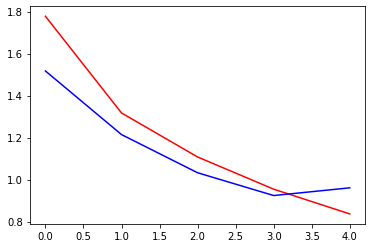

In [ ]:
batch_size = 32

dataloader_train = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
dataloader_val = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

ce_loss = torch.nn.CrossEntropyLoss().to(device)

model = MyResidualNet()

model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epoch_train_losses = []
epoch_val_losses = []
epoch_val_accs = []

for e in range(5):
  train_loss, val_loss, val_acc = one_epoch(model, loss, optimizer, dataloader_train, dataloader_val)

  print("Val loss at epoch {}: {}".format(e, val_loss))
  print("Val acc at epoch {}: {}".format(e, val_acc))

  epoch_train_losses.append(train_loss)
  epoch_val_losses.append(val_loss)
  epoch_val_accs.append(val_acc)
  
plt.plot(epoch_train_losses, c='r')
plt.plot(epoch_val_losses, c='b')
plt.show()